We will create a Pipeline and then create a model using Xgboos with accuracy of 91%

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# from ydata_profiling import ProfileReport
from itertools import product

# preprocessing
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# handling detection
from sklearn.ensemble import IsolationForest

# imbalanced data 
from imblearn.over_sampling import SMOTE, SMOTENC

# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# hyper-parameter tunning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer


# evaluation
from sklearn.metrics import\
    accuracy_score, confusion_matrix, classification_report, \
    f1_score, recall_score, balanced_accuracy_score, precision_score, \
    confusion_matrix, ConfusionMatrixDisplay


# storing the best model
import pickle


In [2]:
pd.set_option('display.max_columns', 30)  # Adjust the number as needed

%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

In [3]:
# loading the dataset
train_data = pd.read_csv("../data/train.csv").drop(columns=["id"])
train_data2 = pd.read_csv("../data/Cir.csv").drop(columns=["ID"]) # original data
data = pd.concat(objs=[train_data, train_data2]).reset_index(drop=True) # combine 2 datasets

# preprocessing

In [4]:
# perform basic pipeline
from src.pipelines import basic_pipeline

# X_train = basic_pipeline.fit_transform(X_train)
data = basic_pipeline.fit_transform(data)

In [5]:
data

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug
0,2.736986,58.991781,1.0,0,0,0,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,2,1
1,7.052055,52.704110,0.0,0,0,0,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0,0
2,9.391781,37.608219,0.0,0,1,1,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,2,0
3,7.057534,50.575342,0.0,0,0,0,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0,0
4,2.158904,45.638356,0.0,0,1,0,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,1.865753,67.046575,0.0,0,0,0,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0,2,0
8319,3.021918,39.027397,0.0,0,0,0,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0,0,0
8320,2.890411,57.038356,0.0,0,0,0,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0,0,0
8321,1.893151,58.041096,0.0,0,0,0,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0,0,0


In [6]:
from src.pipelines import *

advanced_pipeline = Pipeline(
    [   
        ("missing_value_preprocess", FunctionTransformer(func=missing_value_imputation, validate=False)),
        ("outlier_removal_preprocess", FunctionTransformer(func=outlier_removal_quantile, validate=False)),
        ("duplicate_removal_preprocess", FunctionTransformer(func=duplicate_removal, validate=False)),
        ("encoding_preprocess", FunctionTransformer(func=encoding, validate=False)),
        ("imbalanced_fix_preprocess", FunctionTransformer(func=fix_imbalanced_SMOTE, validate=False)),
    ]
)

data = advanced_pipeline.fit_transform(data)
# advanced_pipeline.fit_transform(data)

**NOTE**
one wired thing that stopped SMOTE to work was that it can't handle data with columns more than 15, the solution is to install  
**threadpoolctl** package.  
```bash
pip install -U threadpoolctl
```

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["Status"]), data["Status"])

# Modeling

In [8]:
import xgboost as xgb



In [9]:
# Bayesian search using skopt
np.int = np.int_ # fo fix the conflict with python version

opt = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        "n_estimators": Integer(10, 100),
        "max_depth": Integer(5, 50),
        "num_class": Categorical([3]),
        "learning_rate": Real(0.01, 0.4, prior="uniform"),
        "booster": Categorical(["gbtree", "gblinear"]),
        # "device": Categorical(["cuda"]),
        # "tree_method": Categorical(["hist"]),
        # "early_stopping_rounds": Categorical([0, 5, 10, 20]),
        "eval_metric":  ["logloss"], # mlogloss
    },
    n_iter=32,
    cv=5,
    scoring='accuracy',
    verbose=3,
    random_state=9090,
)

In [10]:
# final_data = data
# X_train, X_test, y_train, y_test = train_test_split(final_data.drop(columns=["Status"]), final_data["Status"])

In [11]:
X_train.head()

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,took_drug,Edema_N,Edema_S,Edema_Y
2860,2.087671,61.846575,0.0,0,1,0,0.800000,257.000000,3.79000,33.000000,1622.000000,170.50,69.000000,140.000000,9.900000,3.0,1,1,0,0
5173,7.147945,52.794521,0.0,0,0,0,0.600000,263.000000,3.85000,52.000000,720.000000,134.85,85.000000,192.000000,9.900000,2.0,0,1,0,0
10760,10.502804,38.163684,0.0,0,1,0,1.399433,341.878045,3.82878,89.849683,1840.195696,170.50,112.914915,212.971638,9.904821,3.0,1,1,0,0
3336,3.369863,46.547945,0.0,0,1,0,0.800000,315.000000,3.94000,13.000000,1637.000000,170.50,71.000000,426.000000,10.800000,4.0,1,1,0,0
5269,0.509589,37.304110,0.0,0,1,1,2.500000,236.000000,3.90000,86.000000,614.000000,136.74,103.000000,236.000000,11.000000,4.0,0,1,0,0


In [13]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END booster=gbtree, eval_metric=logloss, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.913 total time=   3.7s
[CV 2/5] END booster=gbtree, eval_metric=logloss, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.916 total time=   2.7s
[CV 3/5] END booster=gbtree, eval_metric=logloss, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.914 total time=   2.8s
[CV 4/5] END booster=gbtree, eval_metric=logloss, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.909 total time=   2.7s
[CV 5/5] END booster=gbtree, eval_metric=logloss, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.916 total time=   2.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END booster=gbtree, eval_metric=logloss, learning_rate=0.17757114729

In [14]:
opt.best_score_

0.9144176957349884

# Evaluation 

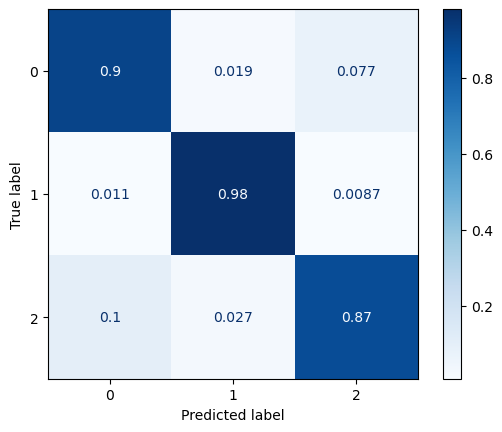

In [16]:
y_ = opt.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_, normalize='true', # display_labels=label_encoder.classes_
    cmap="Blues",
)
plt.show()

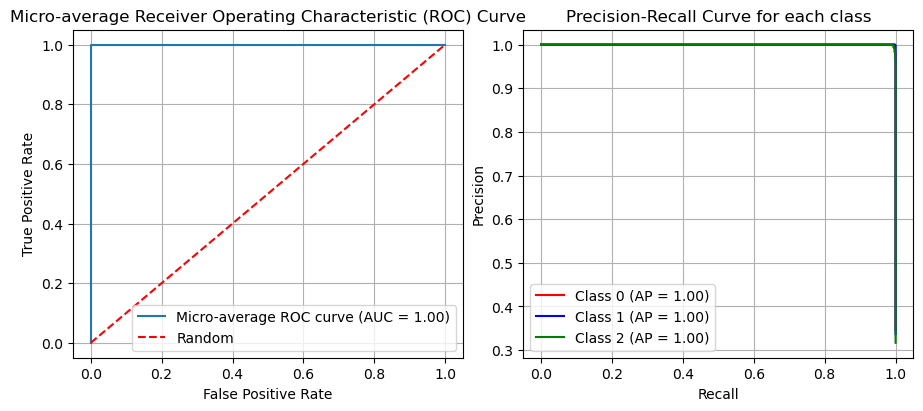

In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Assuming y_true contains true labels and y_pred_probs contains predicted probabilities for each class

# Binarize the labels
y_true_bin = label_binarize(y_, classes=[0, 1, 2])  # Replace classes with your unique class labels
y_pred_probs = opt.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Replace num_classes with the number of unique classes
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute Precision-Recall curve and average precision score for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):  # Replace num_classes with the number of unique classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])

# Compute micro-average precision-recall curve and average precision score
precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_probs.ravel())
average_precision_micro = average_precision_score(y_true_bin, y_pred_probs, average='micro')

# Plot micro-average ROC curve
fig, axes = plt.subplots(1, 2, figsize=(9, 4), layout="constrained")
# axes[0].figure(figsize=(8, 6))
axes[0].plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})')
axes[0].plot([0, 1], [0, 1], 'r--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Micro-average Receiver Operating Characteristic (ROC) Curve')
axes[0].legend()
axes[0].grid()

# Plot Precision-Recall curve for each class
for i, color in zip(range(3), ["red", "blue", "green"]):
    axes[1].plot(recall[i], precision[i], color=color, label=f'Class {i} (AP = {average_precision[i]:.2f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve for each class')
axes[1].legend(loc='best')
axes[1].grid()


In [18]:
from sklearn.metrics import log_loss
log_loss(y_test, opt.predict_proba(X_test))

0.26698982675894817